In [7]:
import json
import yaml
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from IPython.display import display, HTML
import re

project_root = "/home/ubuntu/VOCAL-UDF/"

config = yaml.safe_load(open(os.path.join(project_root, "configs", "config.yaml"), "r"))

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [8]:
def prepare_plot_data():
    plot_data = [] # method, udf_name, interpretation_id, run_id, f1_score

    methods = {
        "VOCAL-UDF": "ninterp=10-nparams=5-kwargs=True-pixels=True-pretrained_models=False-ntrain_distill=100-nselection_samples=500-selection=program-budget=20-llm_method=gpt",
        "Single generation": "ninterp=1-nparams=1-kwargs=False-pixels=True-pretrained_models=False-ntrain_distill=100-nselection_samples=500-selection=program-budget=20-llm_method=gpt",
    }
    udf_names = ["behind", "far", "location_bottom"]

    # Iterate through methods
    for method, method_config_name in methods.items():
        print(f"######## {method} ########")

        for udf_name in udf_names:
            # for run_id in range(5):
            for run_id in range(20):
                for interpretation_id in range(3):
                    try:
                        with open(os.path.join(config['log_dir'], "intent_ambiguity", "clevrer", udf_name, method_config_name, f"interpretation={interpretation_id}-run={run_id}.log"), "r") as f:
                            lines = f.readlines()
                        f1_score = -1
                        for line in lines:
                            if "test F1 score:" in line:
                                f1_score_pattern = r"test F1 score:\s*([0-9.e+-]+)"
                                match = re.search(f1_score_pattern, line)
                                f1_score = float(match.group(1))
                                break
                        if f1_score == -1:
                            print(f"failed task: {udf_name}, {method}, run_id={run_id}, interpretation_id={interpretation_id}")
                            f1_score = 0
                        plot_data.append([method, udf_name, interpretation_id, run_id, f1_score])
                    except Exception as e:
                        print(e)
                        continue

    plot_df = pd.DataFrame(plot_data, columns=["method", "udf_name", "interpretation_id", "run_id", "f1_score"])

    return plot_df

In [9]:
plot_df = prepare_plot_data()

######## VOCAL-UDF ########
[Errno 2] No such file or directory: '/home/ubuntu/VOCAL-UDF/logs/intent_ambiguity/clevrer/behind/ninterp=10-nparams=5-kwargs=True-pixels=True-pretrained_models=False-ntrain_distill=100-nselection_samples=500-selection=program-budget=20-llm_method=gpt/interpretation=0-run=0.log'
[Errno 2] No such file or directory: '/home/ubuntu/VOCAL-UDF/logs/intent_ambiguity/clevrer/behind/ninterp=10-nparams=5-kwargs=True-pixels=True-pretrained_models=False-ntrain_distill=100-nselection_samples=500-selection=program-budget=20-llm_method=gpt/interpretation=1-run=0.log'
[Errno 2] No such file or directory: '/home/ubuntu/VOCAL-UDF/logs/intent_ambiguity/clevrer/behind/ninterp=10-nparams=5-kwargs=True-pixels=True-pretrained_models=False-ntrain_distill=100-nselection_samples=500-selection=program-budget=20-llm_method=gpt/interpretation=2-run=0.log'
[Errno 2] No such file or directory: '/home/ubuntu/VOCAL-UDF/logs/intent_ambiguity/clevrer/behind/ninterp=10-nparams=5-kwargs=True-p

In [10]:
print(plot_df.to_string())

              method udf_name  interpretation_id  run_id  f1_score
0          VOCAL-UDF      far                  0       0  0.767013
1          VOCAL-UDF      far                  0       1  0.169463
2          VOCAL-UDF      far                  0       2  0.866878
3  Single generation      far                  0       0  0.196583
4  Single generation      far                  1       0  0.933004
5  Single generation      far                  0       1  0.774290
6  Single generation      far                  1       1  0.000000
7  Single generation      far                  0       2  0.902623


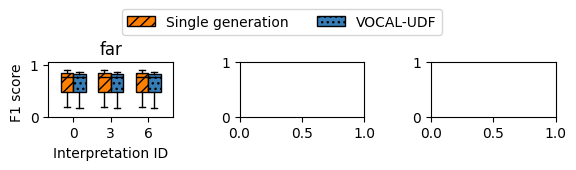

In [ ]:
def plot(plot_df):
    CB_color_cycle = ['#ff7f00', '#377eb8', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
    hatch_patterns = ['///', '...', '\\\\\\', 'xxx', '***', '+++', '|||', '---', 'ooo']
    methods = ["Single generation", "VOCAL-UDF"]
    udf_names = ["behind", "far", "location_bottom"]
    num_methods = len(methods)
    num_interpretations = 3
    # Plotting
    fig, axes = plt.subplots(1, num_interpretations, figsize=(num_interpretations*num_methods, 1.5))
    handles = []
    # Create a boxplota
    for i, udf_name in enumerate(udf_names):
        for j, method in enumerate(methods):
            # method, udf_name, interpretation_id, run_id, f1_score
            group = plot_df[(plot_df['method'] == method) & (plot_df['udf_name'] == udf_name)]
            bp_f1 = axes[i].boxplot(
                [group[(group['interpretation_id'] == interpretation_id)]['f1_score'] for interpretation_id in range(num_interpretations)],
                positions=np.array(range(num_interpretations)) * (num_methods + 1) + j,
                sym='.',
                widths=1,
                showfliers=False,
                patch_artist=True,
                boxprops=dict(facecolor=CB_color_cycle[j], hatch=hatch_patterns[j]),
                medianprops=dict(color='black'))
            handles.append(bp_f1["boxes"][0])

        # Customize the plot labels and legend
        axes[i].set_title(f"{udf_name}")
        axes[i].set(ylabel="F1 score ")
        axes[i].set(xlabel="Interpretation ID")
        axes[i].set_ylim(0, 1.05)
        axes[i].set_xlim(left=-1.5, right=num_interpretations * (num_methods + 1) - 0.5)
        axes[i].set_xticks(np.arange(num_methods / 2 - 0.5, num_interpretations * (num_methods + 1) + num_methods / 2 - 0.5 - 1e-7, num_methods + 1))
    fig.legend(handles, methods, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, prop={"size": 10}, fancybox=True, shadow=False) # On the top
    # fig.legend(handles, method_labels, loc='center left', bbox_to_anchor=(1, 0.6), ncol=2, prop={"size": 10}, fancybox=True, shadow=False) # On the right
    fig.tight_layout()
    fig.savefig(f"figures/intent_ambiguity.pdf", bbox_inches='tight')

    plt.show()

plot(plot_df)

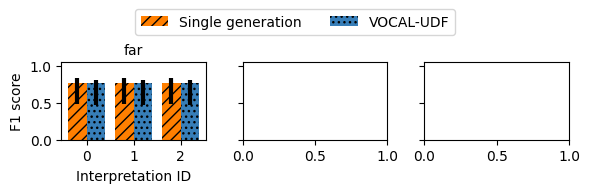

In [ ]:
def plot_bar(plot_df):
    CB_color_cycle = ['#ff7f00', '#377eb8', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
    hatch_patterns = ['///', '...', '\\\\\\', 'xxx', '***', '+++', '|||', '---', 'ooo']
    methods = ["Single generation", "VOCAL-UDF"]
    method_labels = ["Single generation", "VOCAL-UDF"]
    udf_names = ["behind", "far", "location_bottom"]
    num_methods = len(methods)
    num_interpretations = 3

    fig, axes = plt.subplots(1, num_interpretations, figsize=(num_interpretations*num_methods, 1.7), sharey=True)

    # For the legend
    handles = []

    # Width of each bar for each method group
    width = 0.4  # Smaller if you have more methods

    for i, udf_name in enumerate(udf_names):
        ax = axes[i]
        ax.set_title(udf_name, fontsize=10)
        ax.set_xlabel("Interpretation ID")
        ax.set_ylabel("F1 score")
        ax.set_ylim(0, 1.05)
        # For x-ticks: we place each interpretation ID on integer positions
        x_positions = np.arange(num_interpretations)

        for j, method in enumerate(methods):
            # Prepare lists for the median and the error bars (25/75 percentile)
            medians = []
            lower_errors = []
            upper_errors = []

            for interpretation_id in range(num_interpretations):
                # Filter the dataframe
                group = plot_df[
                    (plot_df['method'] == method) &
                    (plot_df['udf_name'] == udf_name) &
                    (plot_df['interpretation_id'] == interpretation_id)
                ]
                f1_scores = group['f1_score'].values
                q1, median, q3 = np.percentile(f1_scores, [25, 50, 75])

                medians.append(median)
                # Errors: difference between median and Q1, and Q3 and median
                lower_errors.append(median - q1)  # how far down from median
                upper_errors.append(q3 - median)  # how far up from median

            # X positions for the bars for this method
            # We offset each method in the group to avoid overlap
            bar_positions = x_positions + j * (width)

            # Plot the bar with error bars
            # yerr expects a 2D array-like: [[lower_errors...],[upper_errors...]]
            bar_container = ax.bar(
                bar_positions,
                medians,
                yerr=[lower_errors, upper_errors],
                width=width,
                color=CB_color_cycle[j % len(CB_color_cycle)],
                hatch=hatch_patterns[j % len(hatch_patterns)],
                # capsize=3,                # length of the error bar caps
                error_kw=dict(
                    lw=3,       # Thickness of the error bar line
                    # capthick=2, # Thickness of the caps
                    # ecolor="dimgray"  # Color of the error bar line
                ),
                # alpha=0.8,
                label=method if i == 0 else ""  # Only label once for legend
            )

            # Collect a handle for the legend only on the first subplot
            if i == 0:
                handles.append(bar_container)

        ax.set_xticks(x_positions + (num_methods - 1) * width / 2)
        ax.set_xticklabels([str(k) for k in range(num_interpretations)])
        ax.set_yticks(np.arange(0, 1.1, 0.5))
    fig.legend(handles, method_labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, prop={"size": 10}, fancybox=True, shadow=False)

    fig.tight_layout()
    fig.savefig("figures/intent_ambiguity.pdf", bbox_inches='tight')
    plt.show()

plot_bar(plot_df)